# Data Ingest

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

IMG_SIZE = (224,224)
CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
BATCH_SIZE = 32
TF_RANDOM_SEED = 42

def make_data_gen(dir_location, shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                              label_mode="int",
                                                               shuffle=shuffle,
                                                              image_size=IMG_SIZE)
train_data = make_data_gen(TRAIN_DIR)

Found 10000 files belonging to 5 classes.


In [3]:
VALID_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data'

valid_data = make_data_gen(VALID_DIR)

Found 10000 files belonging to 5 classes.


In [4]:
TEST_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

test_data = make_data_gen(TEST_DIR, shuffle=False)

Found 10000 files belonging to 5 classes.


# Model 1A - Efficient Nets with Feature Extraction

In [5]:
tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

model_chain = base_model(inputs)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)

model1a = tf.keras.Model(inputs, model_chain)

16705208/16705208 [==============================] - 0s 0us/step


In [6]:
EPOCHS = 5

def train_model(model, callbacks=[]):
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model.fit(train_data, 
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data, 
                     validation_steps=int(0.25 * len(valid_data)),
                     callbacks=callbacks)

In [7]:
model1a_history = train_model(model1a)

Epoch 1/5
313/313 [==============================] - 49s 120ms/step - loss: 0.5439 - accuracy: 0.8239 - val_loss: 0.3554 - val_accuracy: 0.8902
Epoch 2/5
313/313 [==============================] - 20s 63ms/step - loss: 0.3514 - accuracy: 0.8823 - val_loss: 0.3043 - val_accuracy: 0.9046
Epoch 3/5
313/313 [==============================] - 22s 68ms/step - loss: 0.3136 - accuracy: 0.8949 - val_loss: 0.2760 - val_accuracy: 0.9127
Epoch 4/5
313/313 [==============================] - 21s 68ms/step - loss: 0.2924 - accuracy: 0.9026 - val_loss: 0.2618 - val_accuracy: 0.9223
Epoch 5/5
313/313 [==============================] - 22s 68ms/step - loss: 0.2794 - accuracy: 0.9084 - val_loss: 0.2451 - val_accuracy: 0.9255


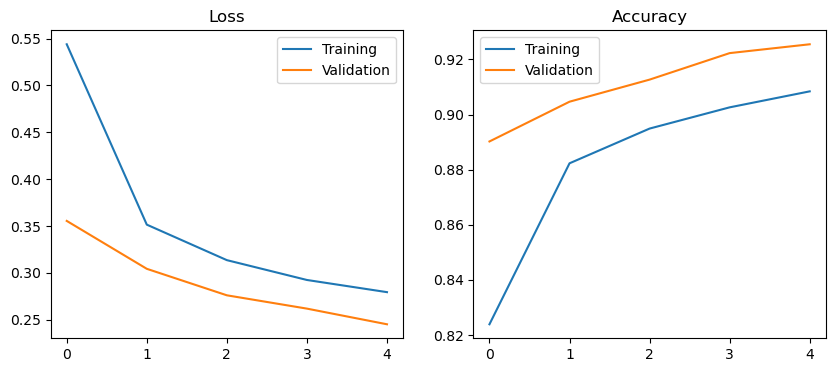

In [8]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy")
    
    plt.legend()
    plt.show()
    
plot_history(model1a_history)

313/313 [==============================] - 16s 48ms/step


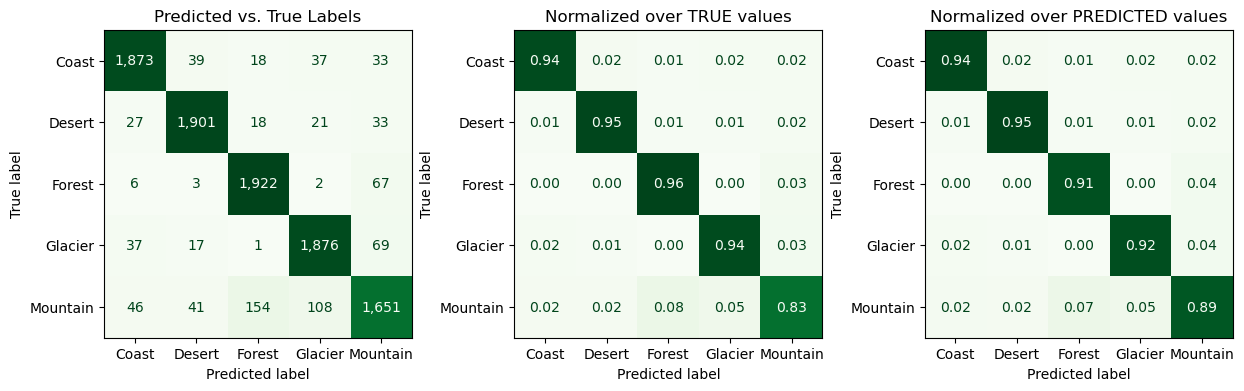

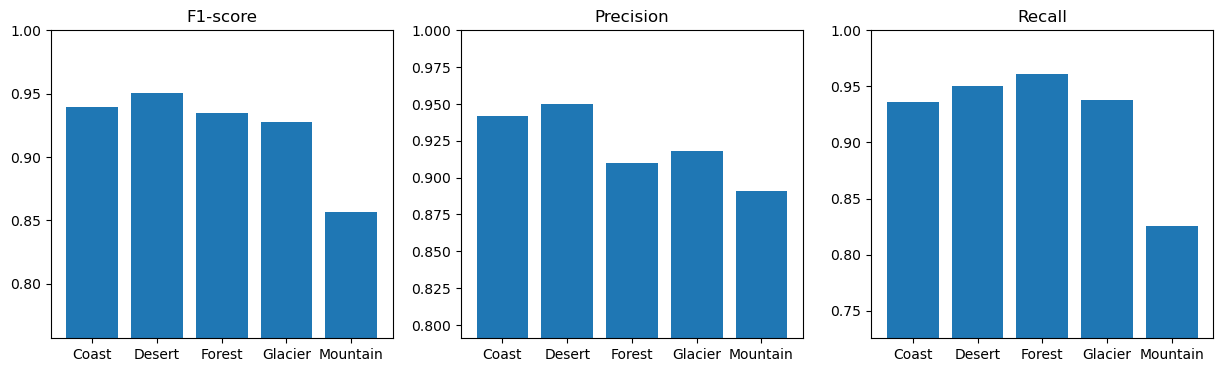

Accuracy: 92.23%


0.9223

In [9]:
def evaluate_model(model):
    y_true = np.concatenate([y for x,y in test_data], axis=0)
    y_predicted = np.argmax(model.predict(test_data), axis=1)
    
    fig, axs = plt.subplots(1,3, figsize=(15,4))
    axs[0].set_title("Predicted vs. True Labels")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predicted,
                                            display_labels=CLASS_LABELS,
                                            values_format=',d', 
                                            colorbar=False,
                                            cmap=plt.get_cmap('Greens'),
                                            ax=axs[0])

    axs[1].set_title("Normalized over TRUE values")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predicted,
                                            normalize='true',
                                            display_labels=CLASS_LABELS,
                                            values_format='.2f', 
                                            colorbar=False,
                                            cmap=plt.get_cmap('Greens'),
                                            ax=axs[1])

    axs[2].set_title("Normalized over PREDICTED values")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predicted,
                                            normalize='pred',
                                            display_labels=CLASS_LABELS,
                                            values_format='.2f', 
                                            colorbar=False,
                                            cmap=plt.get_cmap('Greens'),
                                            ax=axs[2])
    plt.show()
    
    clf_report = classification_report(y_true, y_predicted, output_dict=True)
    f1_scores = [v['f1-score'] for k, v in clf_report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    precision_scores = [v['precision'] for k, v in clf_report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    recall_scores = [v['recall'] for k, v in clf_report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]


    fig, axs = plt.subplots(1, 3, figsize=(15,4))
    axs[0].bar(CLASS_LABELS, f1_scores)
    axs[0].set_title("F1-score")
    axs[0].set_ylim((np.min(f1_scores) - 0.1), 1)

    axs[1].bar(CLASS_LABELS, precision_scores)
    axs[1].set_title("Precision")
    axs[1].set_ylim((np.min(precision_scores) - 0.1), 1)

    axs[2].bar(CLASS_LABELS, recall_scores)
    axs[2].set_title("Recall")
    axs[2].set_ylim((np.min(recall_scores) - 0.1), 1)
    plt.show()
    
    accuracy = clf_report['accuracy']
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

evaluate_model(model1a)

# Model 1B - EfficientNet with Data Augmentation


In [10]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
], name="augmentation_layers")

In [11]:
model1b_checkpoint_filepath = "model1b/best_model.ckpt"
model1b_checkpoint = tf.keras.callbacks.ModelCheckpoint(model1b_checkpoint_filepath,
                                                        monitor='val_accuracy',
                                                        save_best_only=True,
                                                        save_weights_only=False)

In [12]:
tf.random.set_seed(TF_RANDOM_SEED)
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
output_layer = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)


model1b = tf.keras.Model(inputs, output_layer)
model1b.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [13]:
model1b_history = train_model(model1b, [model1b_checkpoint])

Epoch 1/5
313/313 [==============================] - 77s 227ms/step - loss: 0.7306 - accuracy: 0.7443 - val_loss: 0.4497 - val_accuracy: 0.8546
Epoch 2/5
313/313 [==============================] - 72s 229ms/step - loss: 0.5335 - accuracy: 0.8081 - val_loss: 0.4039 - val_accuracy: 0.8738
Epoch 3/5
313/313 [==============================] - 71s 225ms/step - loss: 0.4966 - accuracy: 0.8235 - val_loss: 0.3848 - val_accuracy: 0.8782
Epoch 4/5
313/313 [==============================] - 70s 225ms/step - loss: 0.4751 - accuracy: 0.8280 - val_loss: 0.3598 - val_accuracy: 0.8858
Epoch 5/5
313/313 [==============================] - 72s 231ms/step - loss: 0.4636 - accuracy: 0.8289 - val_loss: 0.3491 - val_accuracy: 0.8902


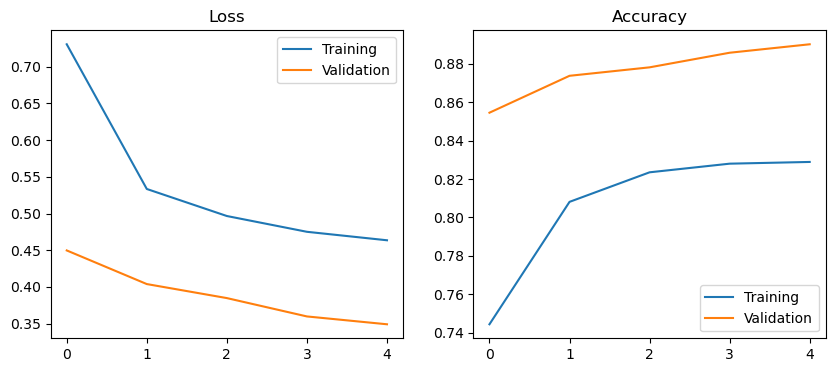

In [14]:
plot_history(model1b_history)

313/313 [==============================] - 17s 50ms/step


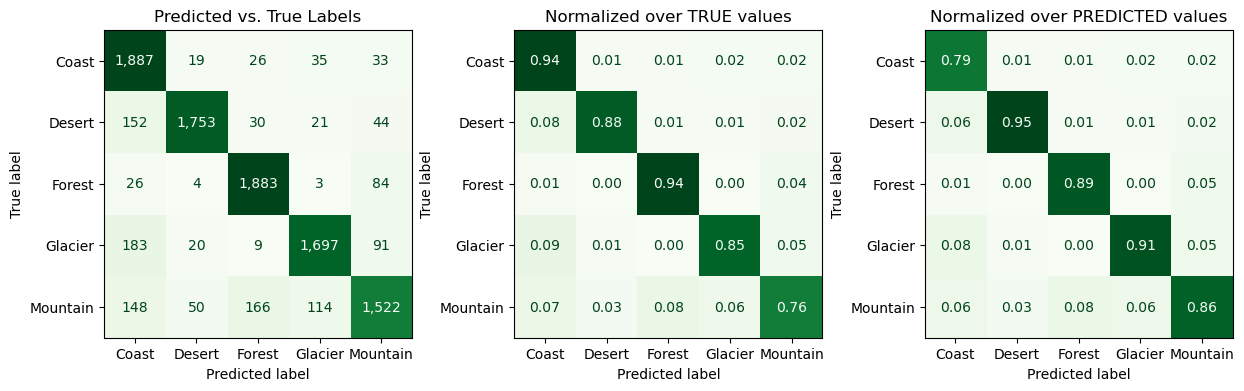

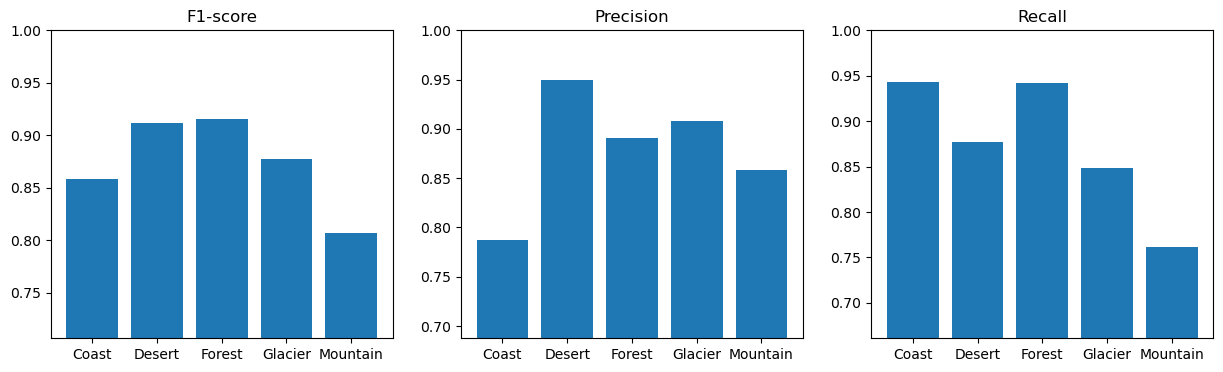

Accuracy: 87.42%


0.8742

In [15]:
evaluate_model(model1b)

# Model 1C - Fine-tuning layers

In [16]:
model1c = tf.keras.models.load_model(model1b_checkpoint_filepath)
model1c.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

313/313 [==============================] - 17s 48ms/step


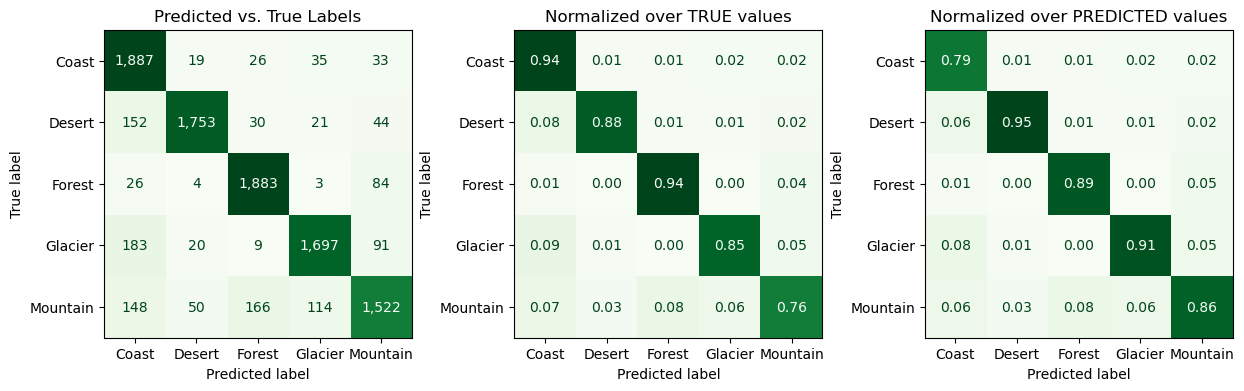

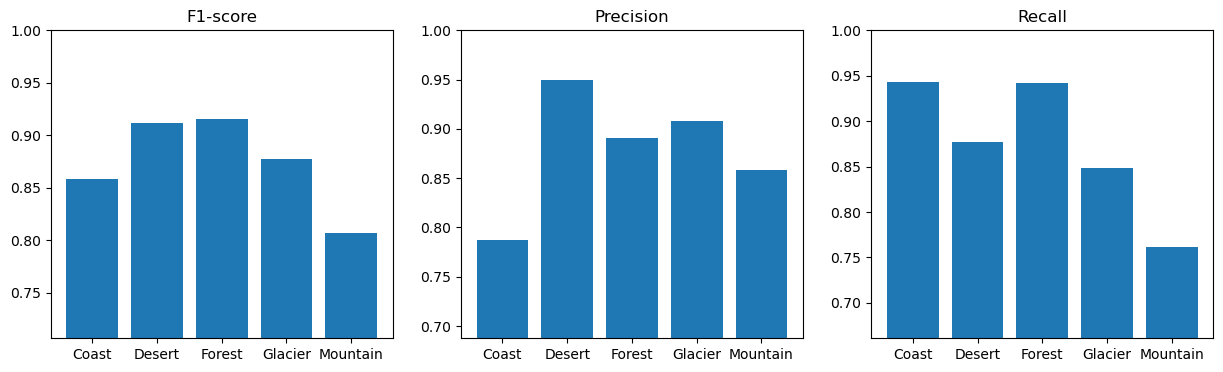

Accuracy: 87.42%


0.8742

In [17]:
evaluate_model(model1c)

In [18]:
for i, layer in enumerate(model1c.layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_3: True
1 augmentation_layers: True
2 efficientnetb0: False
3 global_average_pooling2d_1: True
4 dense_1: True


In [19]:
tf.random.set_seed(TF_RANDOM_SEED)

model1c.layers[2].trainable = True
for i, layer in enumerate(model1c.layers[2].layers):
    layer.trainable = (i >= 227)
    
for i, layer in enumerate(model1c.layers[2].layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_4: False
1 rescaling_1: False
2 normalization_1: False
3 tf.math.truediv_1: False
4 stem_conv_pad: False
5 stem_conv: False
6 stem_bn: False
7 stem_activation: False
8 block1a_dwconv: False
9 block1a_bn: False
10 block1a_activation: False
11 block1a_se_squeeze: False
12 block1a_se_reshape: False
13 block1a_se_reduce: False
14 block1a_se_expand: False
15 block1a_se_excite: False
16 block1a_project_conv: False
17 block1a_project_bn: False
18 block2a_expand_conv: False
19 block2a_expand_bn: False
20 block2a_expand_activation: False
21 block2a_dwconv_pad: False
22 block2a_dwconv: False
23 block2a_bn: False
24 block2a_activation: False
25 block2a_se_squeeze: False
26 block2a_se_reshape: False
27 block2a_se_reduce: False
28 block2a_se_expand: False
29 block2a_se_excite: False
30 block2a_project_conv: False
31 block2a_project_bn: False
32 block2b_expand_conv: False
33 block2b_expand_bn: False
34 block2b_expand_activation: False
35 block2b_dwconv: False
36 block2b_bn: False
37 block2b_

In [20]:
model1c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model1c_history = model1c.fit(train_data,
                            epochs=EPOCHS + 5,
                            batch_size=BATCH_SIZE,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=int(0.25 * len(valid_data)),
                            initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 41s 110ms/step - loss: 0.4742 - accuracy: 0.8301 - val_loss: 0.3255 - val_accuracy: 0.8918
Epoch 7/10
313/313 [==============================] - 32s 101ms/step - loss: 0.4206 - accuracy: 0.8518 - val_loss: 0.3035 - val_accuracy: 0.8978
Epoch 8/10
313/313 [==============================] - 31s 97ms/step - loss: 0.3892 - accuracy: 0.8609 - val_loss: 0.2751 - val_accuracy: 0.9050
Epoch 9/10
313/313 [==============================] - 31s 97ms/step - loss: 0.3563 - accuracy: 0.8730 - val_loss: 0.2457 - val_accuracy: 0.9203
Epoch 10/10
313/313 [==============================] - 31s 98ms/step - loss: 0.3315 - accuracy: 0.8820 - val_loss: 0.2342 - val_accuracy: 0.9239


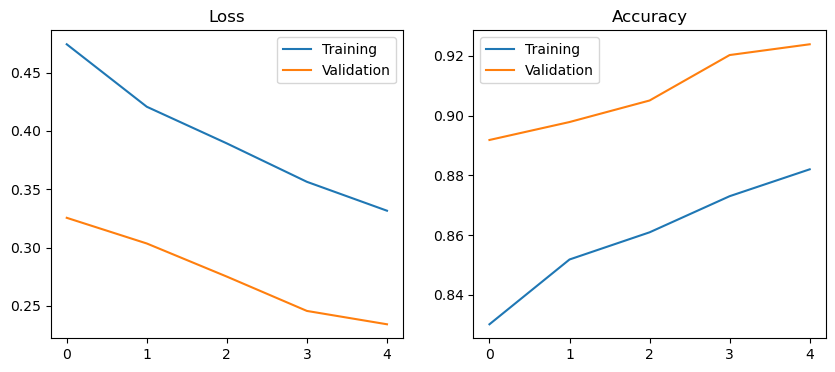

In [21]:
plot_history(model1c_history)

In [22]:
def plot_fine_tune_history(pre_history, post_history):
    fig, axs = plt.subplots( 1, 2,figsize=(10, 4))
    axs[0].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["loss"] + post_history.history["loss"],
            label="Training")
    axs[0].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["val_loss"] + post_history.history["val_loss"],
            label="Validation")
    axs[0].axvline(len(pre_history.epoch) - 1, 0, 1, color="red", linestyle="--")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    axs[1].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["accuracy"] + post_history.history["accuracy"],
            label="Training")
    axs[1].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["val_accuracy"] + post_history.history["val_accuracy"],
            label="Validation")
    axs[1].axvline(len(pre_history.epoch) - 1, 0, 1, color="red", linestyle="--")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    plt.show()

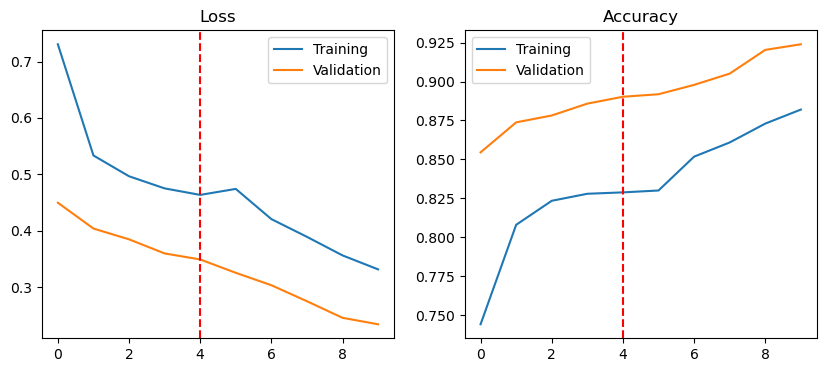

In [23]:
plot_fine_tune_history(model1b_history, model1c_history)

313/313 [==============================] - 17s 50ms/step


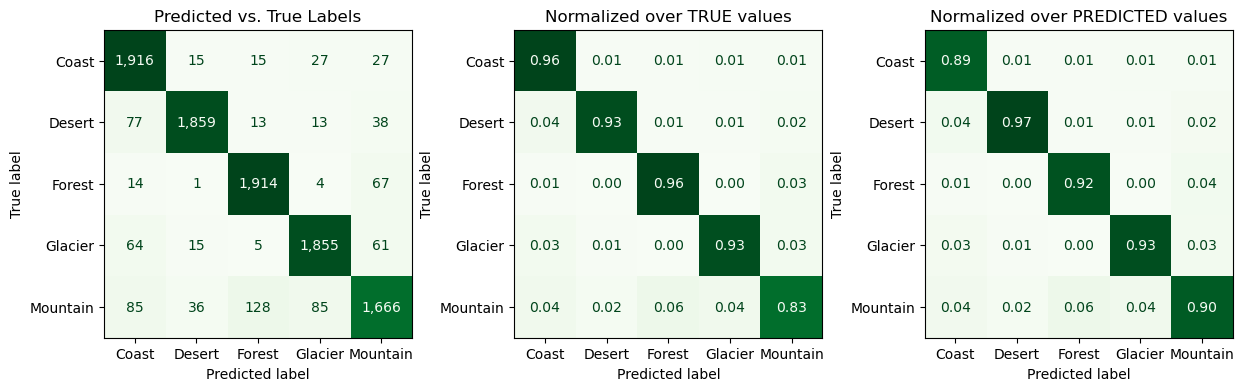

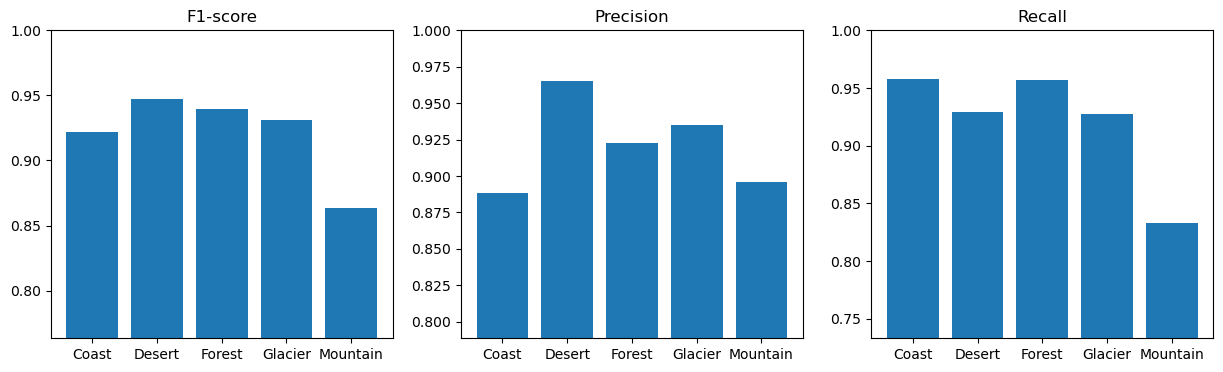

Accuracy: 92.10%


0.921

In [24]:
evaluate_model(model1c)

# Model 2A - ResNet with Feature Extraction

In [25]:
tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,))

model_chain = tf.keras.layers.Rescaling(1./255)(inputs)

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.activity_regularizertrainable = False
model_chain = base_model(model_chain)

model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)

model2a = tf.keras.models.Model(inputs, model_chain)

94765736/94765736 [==============================] - 0s 0us/step


In [26]:
model2a_history = train_model(model2a)

Epoch 1/5
313/313 [==============================] - 67s 192ms/step - loss: 0.8350 - accuracy: 0.7230 - val_loss: 1.7376 - val_accuracy: 0.1815
Epoch 2/5
313/313 [==============================] - 59s 188ms/step - loss: 0.5713 - accuracy: 0.7999 - val_loss: 2.4240 - val_accuracy: 0.2115
Epoch 3/5
313/313 [==============================] - 61s 194ms/step - loss: 0.5398 - accuracy: 0.8178 - val_loss: 0.9241 - val_accuracy: 0.6474
Epoch 4/5
313/313 [==============================] - 59s 189ms/step - loss: 0.4275 - accuracy: 0.8519 - val_loss: 0.4953 - val_accuracy: 0.8205
Epoch 5/5
313/313 [==============================] - 59s 189ms/step - loss: 0.3447 - accuracy: 0.8806 - val_loss: 0.5759 - val_accuracy: 0.7969


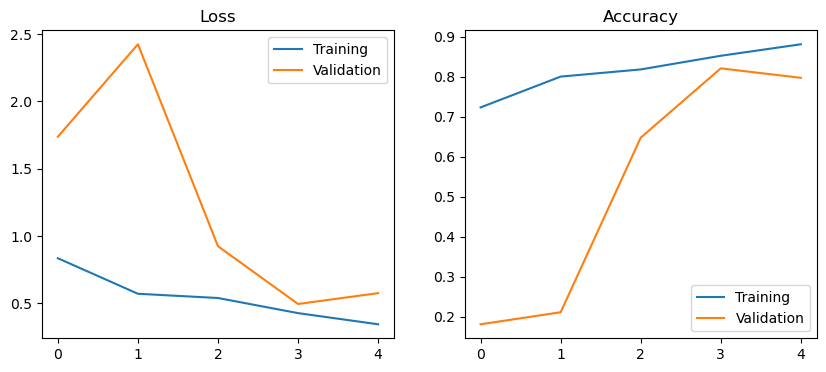

In [27]:
plot_history(model2a_history)

313/313 [==============================] - 19s 59ms/step


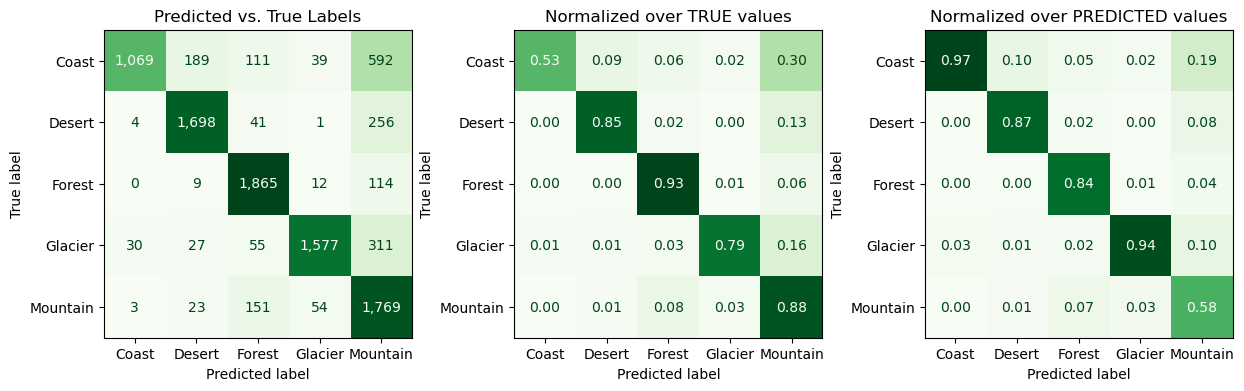

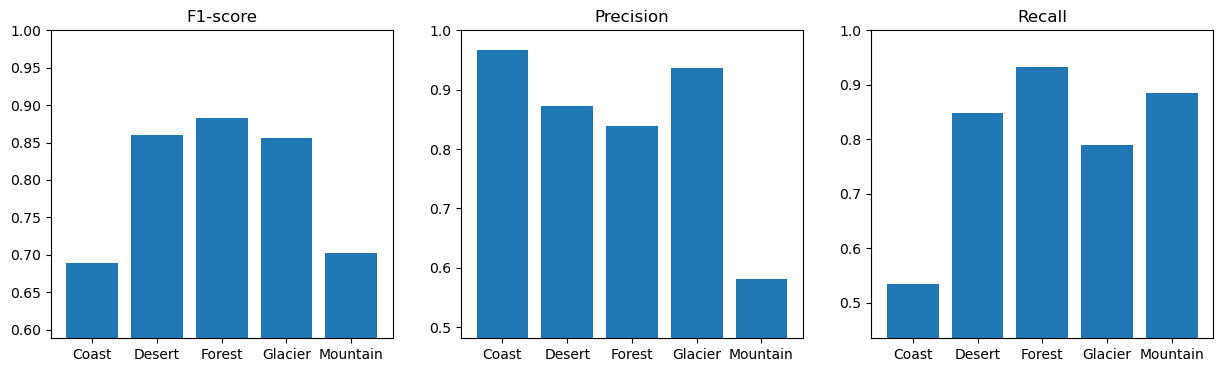

Accuracy: 79.78%


0.7978

In [28]:
evaluate_model(model2a)

# Model 2B - Resnet Model with Data Augmentation Layers

In [29]:
tf.random.set_seed(TF_RANDOM_SEED)

data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [30]:
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)
model_chain = tf.keras.layers.Rescaling(1./255)(model_chain)

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False
model_chain = base_model(model_chain)

model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)
model2b = tf.keras.Model(inputs,  model_chain)

In [31]:
model2b_checkpoint_filepath = "model2b/best_model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model2b_checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=False)
model2b_history = train_model(model2b, [model_checkpoint])

Epoch 1/5
313/313 [==============================] - 64s 193ms/step - loss: 1.5864 - accuracy: 0.2578 - val_loss: 1.5260 - val_accuracy: 0.3526
Epoch 2/5
313/313 [==============================] - 37s 117ms/step - loss: 1.5416 - accuracy: 0.2983 - val_loss: 1.4998 - val_accuracy: 0.3454
Epoch 3/5
313/313 [==============================] - 60s 191ms/step - loss: 1.5284 - accuracy: 0.3164 - val_loss: 1.4883 - val_accuracy: 0.3702
Epoch 4/5
313/313 [==============================] - 37s 117ms/step - loss: 1.5000 - accuracy: 0.3477 - val_loss: 1.4624 - val_accuracy: 0.3630
Epoch 5/5
313/313 [==============================] - 61s 194ms/step - loss: 1.4903 - accuracy: 0.3508 - val_loss: 1.4528 - val_accuracy: 0.3986


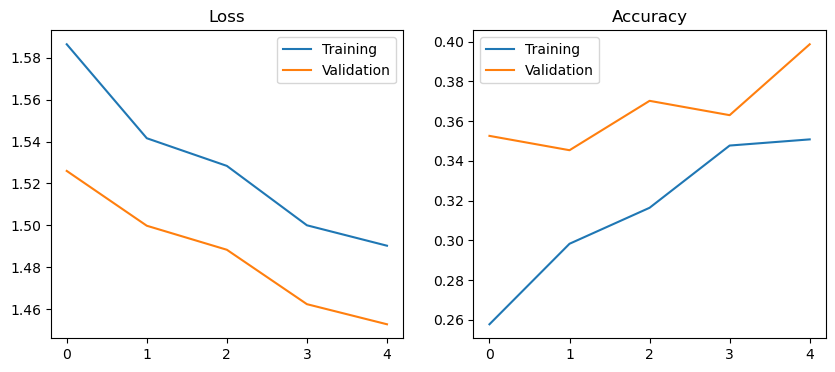

In [32]:
plot_history(model2b_history)

313/313 [==============================] - 20s 60ms/step


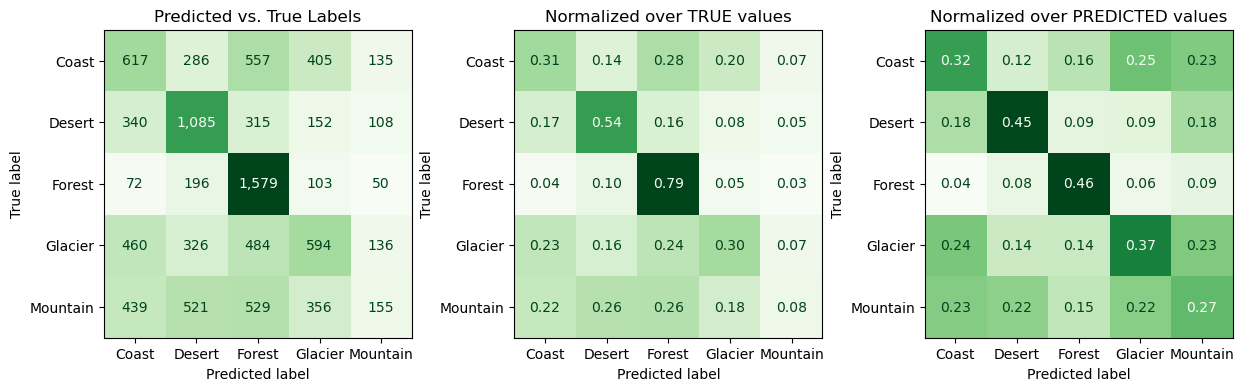

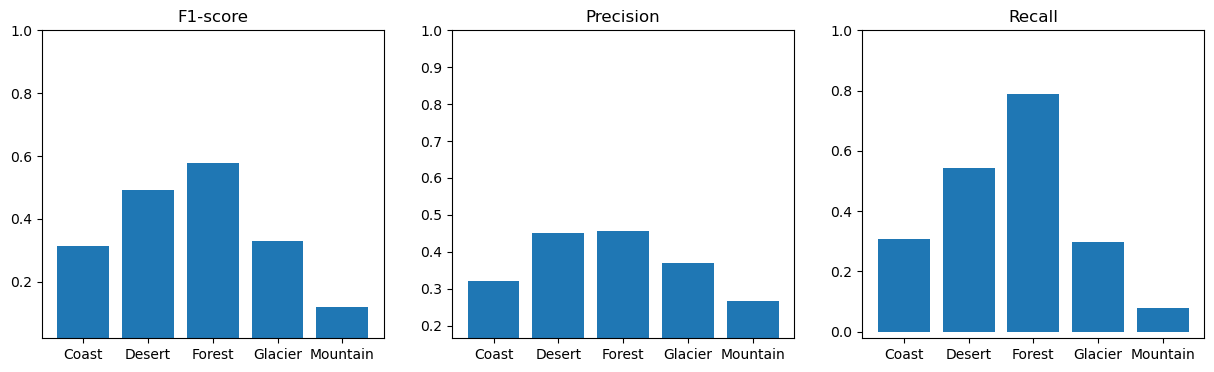

Accuracy: 40.30%


0.403

In [33]:
evaluate_model(model2b)

# Model 3C - Resnet Model with Fine-Tuning

313/313 [==============================] - 20s 61ms/step


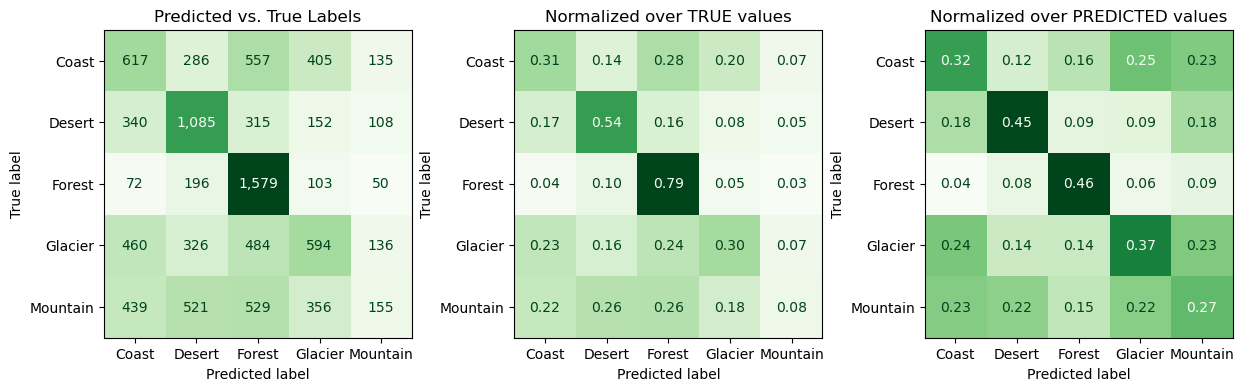

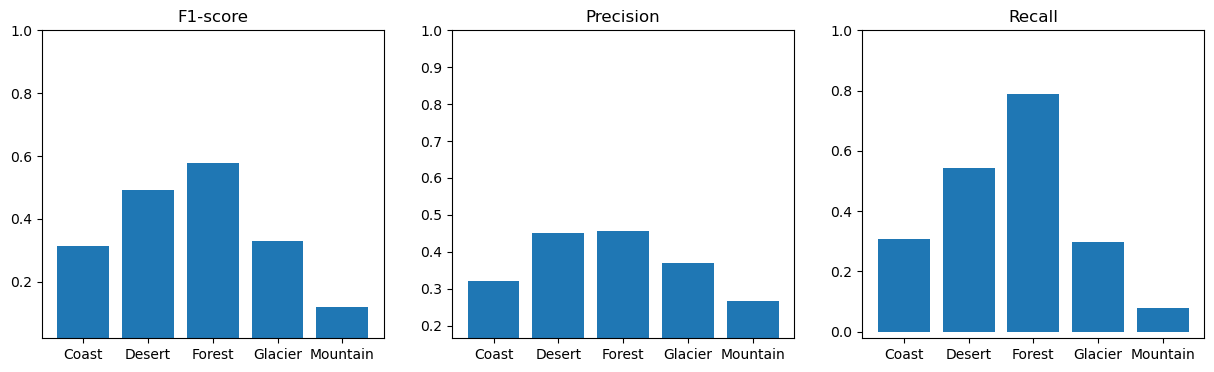

Accuracy: 40.30%


0.403

In [34]:
model2c = tf.keras.models.load_model(model2b_checkpoint_filepath)
evaluate_model(model2c)

In [35]:
model2c.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 1024

In [36]:
for idx, layer in enumerate(model2c.layers):
    print(f"{idx} {layer.name}: {layer.trainable}")

0 input_7: True
1 augmentation_layers: True
2 rescaling_3: True
3 resnet50: False
4 global_average_pooling2d_3: True
5 dense_3: True


In [37]:
model2c.layers[3].trainable=True

for layer in model2c.layers[3].layers[:165]:
    layer.trainable = False

for layer in model2c.layers[3].layers[165:]:
    layer.trainable = True

In [38]:
for idx, layer in enumerate(model2c.layers[3].layers):
    print(f"{idx} {layer.name}: {layer.trainable}")

0 input_8: False
1 conv1_pad: False
2 conv1_conv: False
3 conv1_bn: False
4 conv1_relu: False
5 pool1_pad: False
6 pool1_pool: False
7 conv2_block1_1_conv: False
8 conv2_block1_1_bn: False
9 conv2_block1_1_relu: False
10 conv2_block1_2_conv: False
11 conv2_block1_2_bn: False
12 conv2_block1_2_relu: False
13 conv2_block1_0_conv: False
14 conv2_block1_3_conv: False
15 conv2_block1_0_bn: False
16 conv2_block1_3_bn: False
17 conv2_block1_add: False
18 conv2_block1_out: False
19 conv2_block2_1_conv: False
20 conv2_block2_1_bn: False
21 conv2_block2_1_relu: False
22 conv2_block2_2_conv: False
23 conv2_block2_2_bn: False
24 conv2_block2_2_relu: False
25 conv2_block2_3_conv: False
26 conv2_block2_3_bn: False
27 conv2_block2_add: False
28 conv2_block2_out: False
29 conv2_block3_1_conv: False
30 conv2_block3_1_bn: False
31 conv2_block3_1_relu: False
32 conv2_block3_2_conv: False
33 conv2_block3_2_bn: False
34 conv2_block3_2_relu: False
35 conv2_block3_3_conv: False
36 conv2_block3_3_bn: False
37

In [39]:
model2c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model2c_history = model2c.fit(train_data,
                                epochs=EPOCHS+5,
                                steps_per_epoch=len(train_data),
                                validation_data=valid_data,
                                validation_steps=len(valid_data),
                                initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 57s 170ms/step - loss: 1.2926 - accuracy: 0.4545 - val_loss: 1.5448 - val_accuracy: 0.3489
Epoch 7/10
313/313 [==============================] - 52s 166ms/step - loss: 1.1668 - accuracy: 0.5147 - val_loss: 1.2173 - val_accuracy: 0.5006
Epoch 8/10
313/313 [==============================] - 52s 166ms/step - loss: 1.1033 - accuracy: 0.5476 - val_loss: 1.2402 - val_accuracy: 0.4746
Epoch 9/10
313/313 [==============================] - 52s 165ms/step - loss: 1.0711 - accuracy: 0.5687 - val_loss: 2.0250 - val_accuracy: 0.3631
Epoch 10/10
313/313 [==============================] - 52s 166ms/step - loss: 1.0495 - accuracy: 0.5670 - val_loss: 2.3111 - val_accuracy: 0.3621


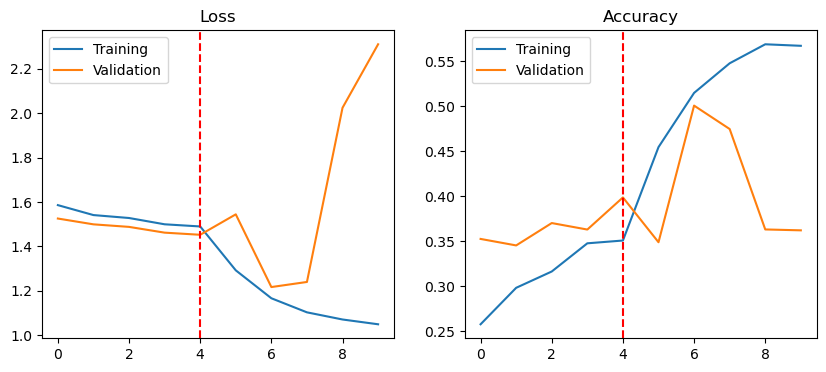

In [40]:
plot_fine_tune_history(model2b_history, model2c_history)

313/313 [==============================] - 19s 58ms/step


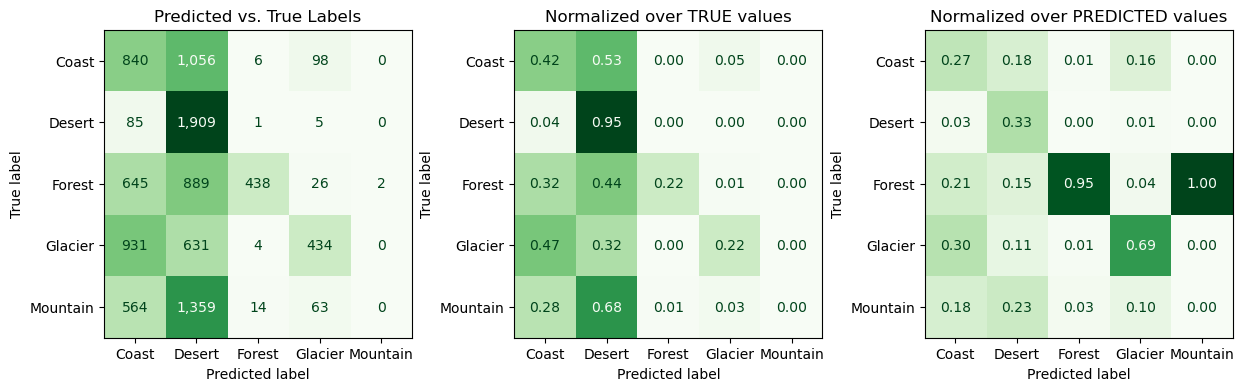

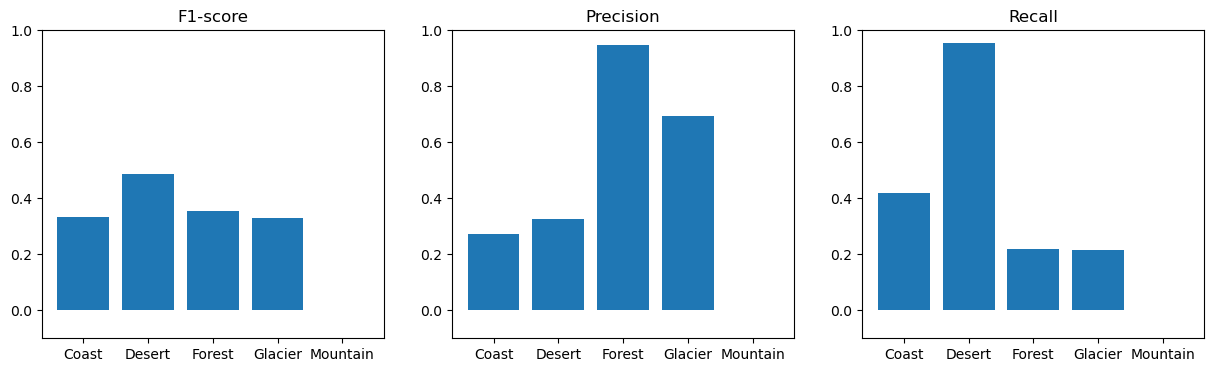

Accuracy: 36.21%


0.3621

In [41]:
evaluate_model(model2c)

# Model 3A - Inception Model with Feature Extraction

In [42]:
tf.random.set_seed(TF_RANDOM_SEED)

base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = tf.keras.layers.Rescaling(1./255)(inputs)
model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)

model3a = tf.keras.Model(inputs, model_chain)

87910968/87910968 [==============================] - 1s 0us/step


In [43]:
model3a_history = train_model(model3a)

Epoch 1/5
313/313 [==============================] - 28s 76ms/step - loss: 0.6379 - accuracy: 0.7713 - val_loss: 0.4546 - val_accuracy: 0.8393
Epoch 2/5
313/313 [==============================] - 23s 71ms/step - loss: 0.4585 - accuracy: 0.8395 - val_loss: 0.4480 - val_accuracy: 0.8429
Epoch 3/5
313/313 [==============================] - 23s 72ms/step - loss: 0.4153 - accuracy: 0.8542 - val_loss: 0.3706 - val_accuracy: 0.8766
Epoch 4/5
313/313 [==============================] - 23s 72ms/step - loss: 0.3822 - accuracy: 0.8684 - val_loss: 0.3641 - val_accuracy: 0.8758
Epoch 5/5
313/313 [==============================] - 23s 72ms/step - loss: 0.3696 - accuracy: 0.8710 - val_loss: 0.3329 - val_accuracy: 0.8858


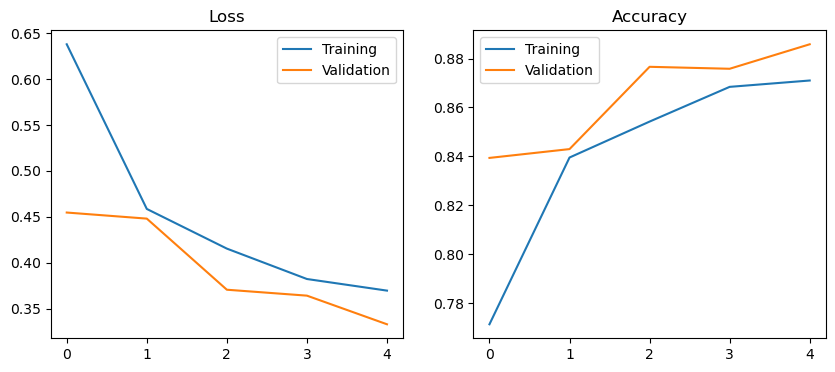

In [44]:
plot_history(model3a_history)

313/313 [==============================] - 17s 51ms/step


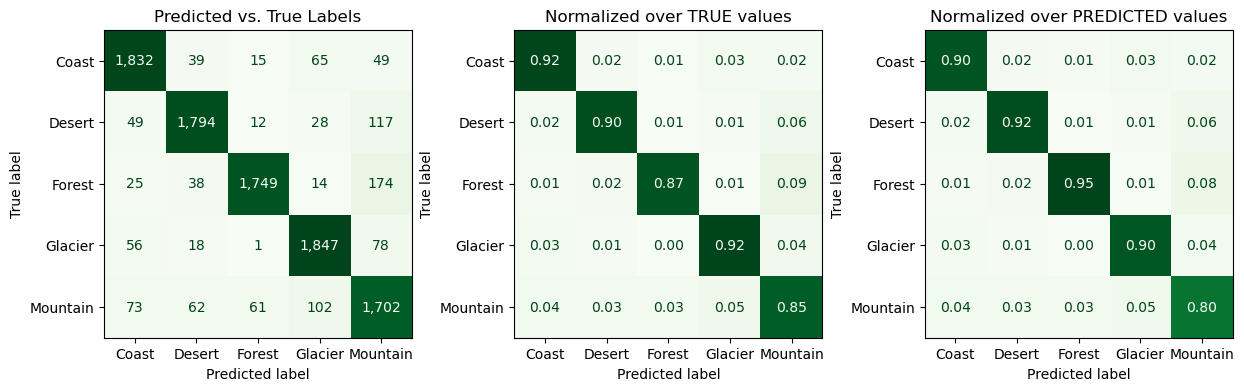

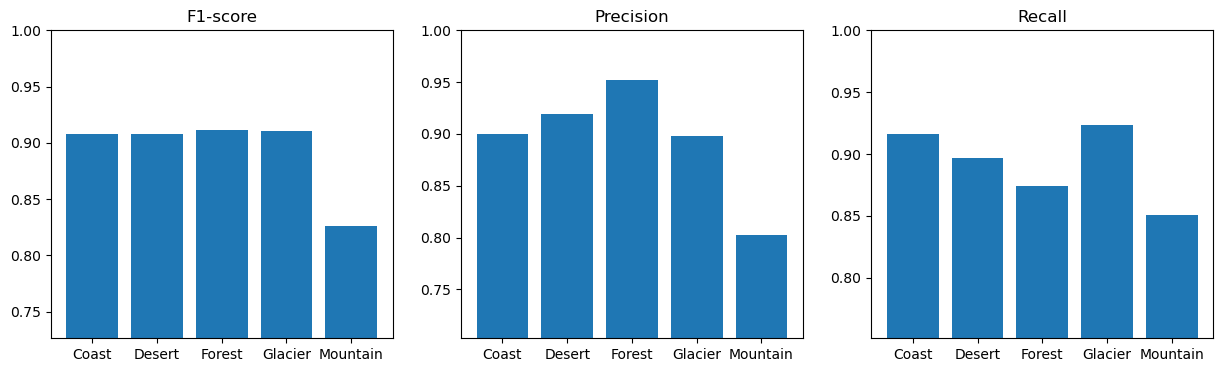

Accuracy: 89.24%


0.8924

In [45]:
evaluate_model(model3a)

# Model 3B - Inception Model with Data Augmentation

In [46]:
tf.random.set_seed(TF_RANDOM_SEED)

augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)
model_chain = tf.keras.layers.Rescaling(1./255)(model_chain)
model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)
model3b = tf.keras.Model(inputs, model_chain)

In [47]:
model3b_checkpoint_filepath = "model3b/best_model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model3b_checkpoint_filepath, 
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=False)

model3b_history = train_model(model3b, [model_checkpoint])

Epoch 1/5
313/313 [==============================] - 74s 221ms/step - loss: 0.8785 - accuracy: 0.6709 - val_loss: 0.5656 - val_accuracy: 0.7985
Epoch 2/5
313/313 [==============================] - 69s 220ms/step - loss: 0.6816 - accuracy: 0.7524 - val_loss: 0.5286 - val_accuracy: 0.8117
Epoch 3/5
313/313 [==============================] - 69s 220ms/step - loss: 0.6510 - accuracy: 0.7638 - val_loss: 0.5045 - val_accuracy: 0.8225
Epoch 4/5
313/313 [==============================] - 33s 103ms/step - loss: 0.6553 - accuracy: 0.7611 - val_loss: 0.5474 - val_accuracy: 0.7957
Epoch 5/5
313/313 [==============================] - 33s 103ms/step - loss: 0.6143 - accuracy: 0.7772 - val_loss: 0.5168 - val_accuracy: 0.8165


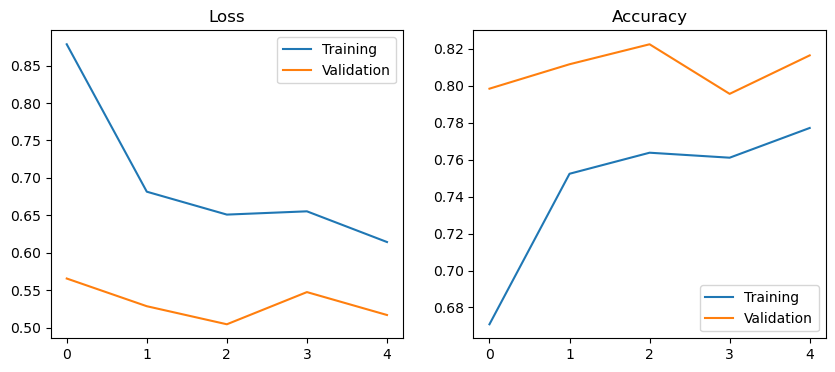

In [48]:
plot_history(model3b_history)

313/313 [==============================] - 20s 56ms/step


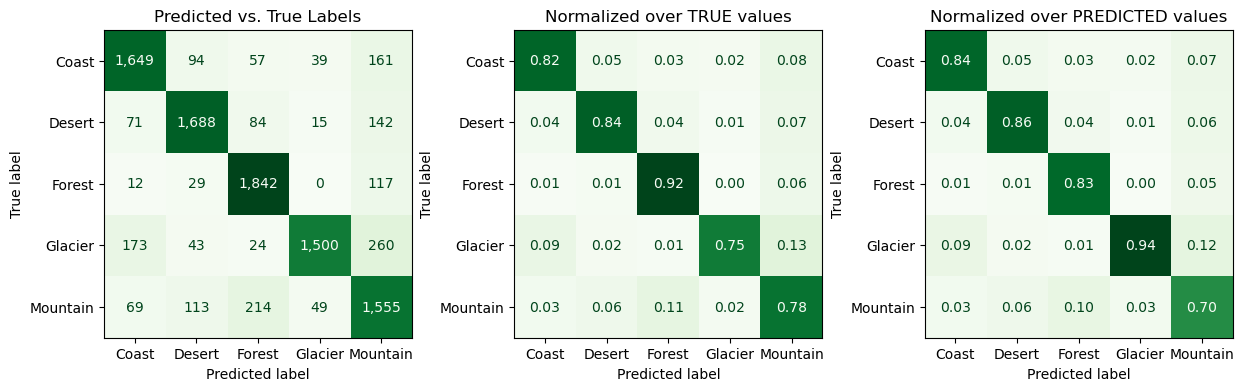

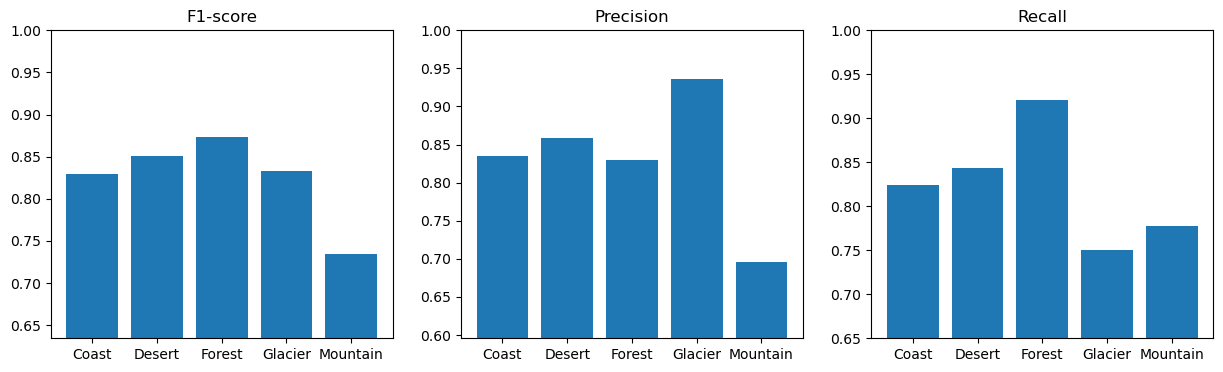

Accuracy: 82.34%


0.8234

In [49]:
evaluate_model(model3b)

# Model 3C - Inception Model with Fine - Tuning

313/313 [==============================] - 18s 54ms/step


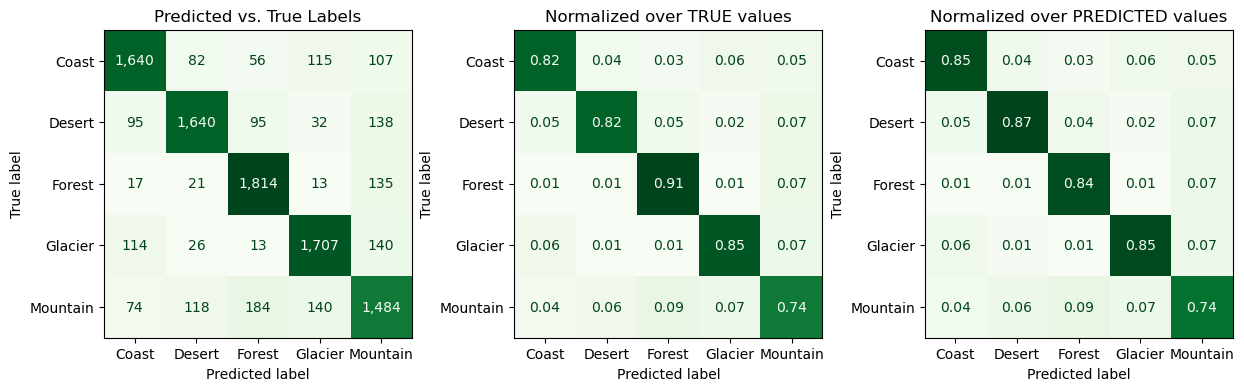

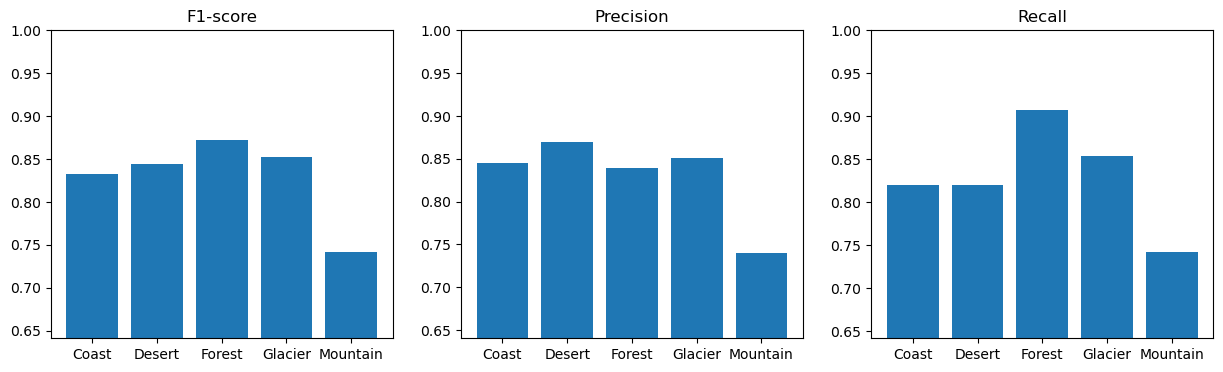

Accuracy: 82.85%


0.8285

In [50]:
model3c = tf.keras.models.load_model(model3b_checkpoint_filepath)
evaluate_model(model3c)

In [51]:
# What are the layers?
for index, layer in enumerate(model3c.layers):
    print(f"{index} {layer.name}: {layer.trainable}")

0 input_12: True
1 sequential_1: True
2 rescaling_5: True
3 inception_v3: False
4 global_average_pooling2d_5: True
5 dense_5: True


In [52]:
model3c.layers[3].trainable = True
for layer in model3c.layers[3].layers[:-10]:
    layer.trainable = False

for index, layer in enumerate(model3c.layers[3].layers):
    print(f"{index} {layer.name}: {layer.trainable}")

0 input_11: False
1 conv2d_94: False
2 batch_normalization_94: False
3 activation_94: False
4 conv2d_95: False
5 batch_normalization_95: False
6 activation_95: False
7 conv2d_96: False
8 batch_normalization_96: False
9 activation_96: False
10 max_pooling2d_4: False
11 conv2d_97: False
12 batch_normalization_97: False
13 activation_97: False
14 conv2d_98: False
15 batch_normalization_98: False
16 activation_98: False
17 max_pooling2d_5: False
18 conv2d_102: False
19 batch_normalization_102: False
20 activation_102: False
21 conv2d_100: False
22 conv2d_103: False
23 batch_normalization_100: False
24 batch_normalization_103: False
25 activation_100: False
26 activation_103: False
27 average_pooling2d_9: False
28 conv2d_99: False
29 conv2d_101: False
30 conv2d_104: False
31 conv2d_105: False
32 batch_normalization_99: False
33 batch_normalization_101: False
34 batch_normalization_104: False
35 batch_normalization_105: False
36 activation_99: False
37 activation_101: False
38 activation_104

In [53]:
model3c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model3c_history = model3c.fit(train_data,
                             epochs=EPOCHS + 5,
                             steps_per_epoch=len(train_data),
                             validation_data=valid_data,
                             validation_steps=len(valid_data),
                             initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 52s 151ms/step - loss: 0.6152 - accuracy: 0.7695 - val_loss: 0.4874 - val_accuracy: 0.8299
Epoch 7/10
313/313 [==============================] - 46s 144ms/step - loss: 0.5949 - accuracy: 0.7861 - val_loss: 0.4876 - val_accuracy: 0.8294
Epoch 8/10
313/313 [==============================] - 46s 145ms/step - loss: 0.5917 - accuracy: 0.7897 - val_loss: 0.4856 - val_accuracy: 0.8310
Epoch 9/10
313/313 [==============================] - 46s 144ms/step - loss: 0.5828 - accuracy: 0.7872 - val_loss: 0.4852 - val_accuracy: 0.8316
Epoch 10/10
313/313 [==============================] - 46s 146ms/step - loss: 0.5882 - accuracy: 0.7869 - val_loss: 0.4799 - val_accuracy: 0.8318


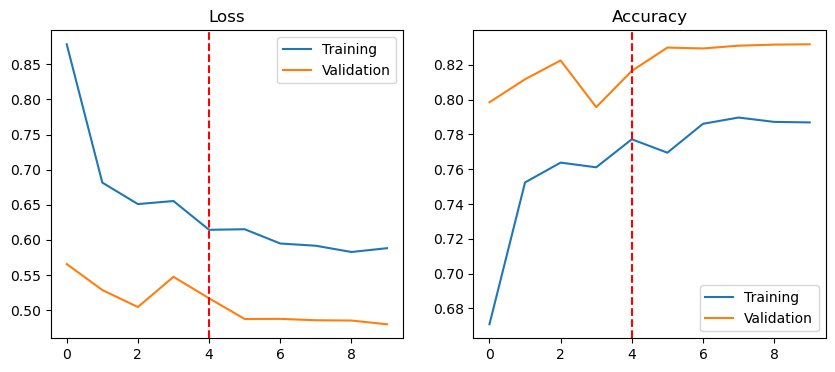

In [54]:
plot_fine_tune_history(model3b_history, model3c_history)

313/313 [==============================] - 18s 53ms/step


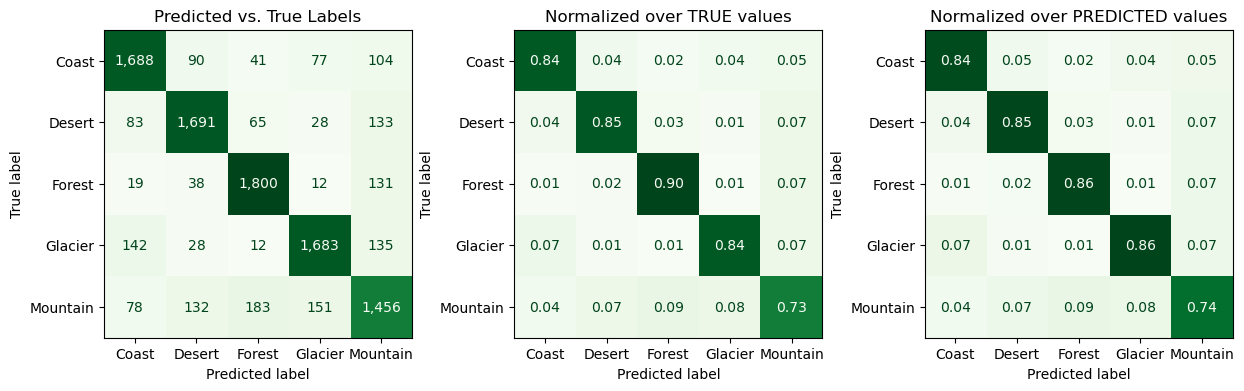

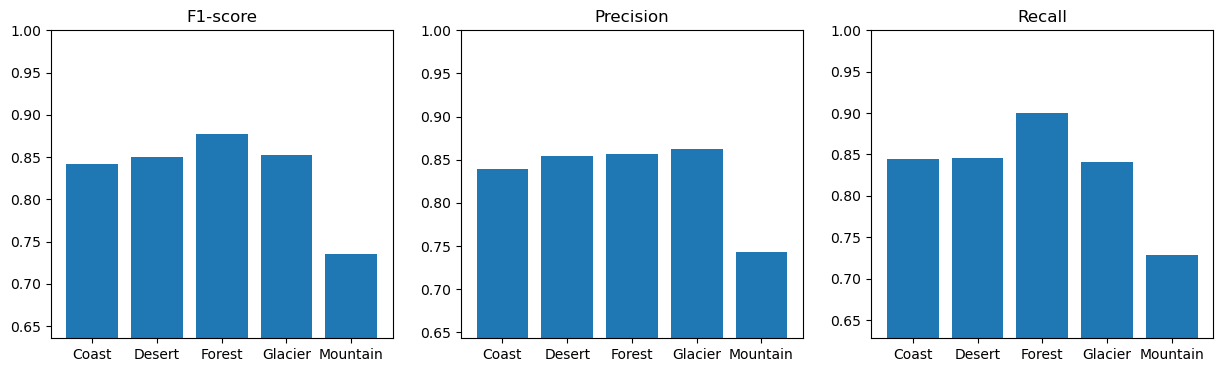

Accuracy: 83.18%


0.8318

In [55]:
evaluate_model(model3c)